Phase 2 Extension: Generative Simulations in 80-20 vs 70-30 Bandits task

This notebook extends the paper's generative simulations by examining how models behave in a noisier environment (70-30) compared to the original 80-20 condition.

Models:
RFLR - generative, mouse-fit parameters
HMM Thompson Sampling - true task parameters
Sticky / Cost-Gated HMM

Metrics:
Reward per session
Reward per switch

Hypothesis:
Standard HMM will over-swicth in 70-30, while RFLR and Sticky HMM will maintain higher reward per switch. 

In [201]:
# Imports and paths
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cwd = os.getcwd()
if os.path.exists(os.path.join(cwd, "reproduction", "2ABT_behaviour_models")):
    PROJECT_ROOT = cwd
elif os.path.exists(os.path.join(cwd, "..", "reproduction", "2ABT_behaviour_models")):
    PROJECT_ROOT = os.path.abspath(os.path.join(cwd, ".."))
else:
    raise FileNotFoundError(
        "Could not locate reproduction/2ABT_behaviour_models from current working directory"
    )

BEHAV_DIR = os.path.join(PROJECT_ROOT, "reproduction", "2ABT_behaviour_models")
if BEHAV_DIR not in sys.path:
    sys.path.insert(0, BEHAV_DIR)

import model_simulations as sim
import model_fitting as fit

OUTDIR = os.path.join(PROJECT_ROOT, "Extensions", "phase2_generative")
os.makedirs(OUTDIR, exist_ok=True)

np.random.seed(0)

In [202]:
# Load mouse data (REAL sessions + REAL latent states from Target)
df = pd.read_csv(os.path.join(BEHAV_DIR, "bandit_data.csv")).copy()

# Keep only the two conditions we care about
df = df[df["Condition"].isin(["70-30", "80-20"])].copy()

# Sort so sessions are in correct trial order
df = df.sort_values(["Session", "Trial"])


def build_sessions_and_states(df_cond):
    mouse_sessions = []  # list of (choices, rewards)
    state_sessions = []  # list of state arrays (Target)
    meta = []  # optional: (Mouse, Session)

    for sess, g in df_cond.groupby("Session"):
        choices = g["Decision"].astype(int).to_numpy()
        rewards = g["Reward"].astype(int).to_numpy()
        states = g["Target"].astype(int).to_numpy()

        mouse_sessions.append((choices, rewards))
        state_sessions.append(states)
        meta.append((g["Mouse"].iloc[0], sess))

    return mouse_sessions, state_sessions, meta


df80 = df[df["Condition"] == "80-20"].copy()
df70 = df[df["Condition"] == "70-30"].copy()

mouse_sessions_80, states_80_real, meta_80 = build_sessions_and_states(df80)
mouse_sessions_70, states_70_real, meta_70 = build_sessions_and_states(df70)

len(mouse_sessions_80), len(mouse_sessions_70), len(states_80_real), len(states_70_real)

(159, 200, 159, 200)

In [203]:
# Fit RFLR on Mouse 80-20 and 70-30 (REAL data)

# Fit on 80-20
rflr_params_80, nll_80 = fit.fit_with_sgd(
    fit.log_probability_rflr,
    mouse_sessions_80,
    num_steps=4000,
    step_size=1e-2,
    init_parameters=(0.0, 1.0, 2.0),
)
alpha_80, beta_80, tau_80 = map(float, rflr_params_80)

# Fit on 70-30
rflr_params_70, nll_70 = fit.fit_with_sgd(
    fit.log_probability_rflr,
    mouse_sessions_70,
    num_steps=4000,
    step_size=1e-2,
    init_parameters=(0.0, 1.0, 2.0),
)
alpha_70, beta_70, tau_70 = map(float, rflr_params_70)

(alpha_80, beta_80, tau_80), (alpha_70, beta_70, tau_70), (nll_80, nll_70)

iteration  0 neg ll:  0.25747707
iteration  1000 neg ll:  0.18779886
iteration  2000 neg ll:  0.18509173
iteration  3000 neg ll:  0.1840569
iteration  0 neg ll:  0.30199584
iteration  1000 neg ll:  0.20443213
iteration  2000 neg ll:  0.2003353
iteration  3000 neg ll:  0.1991485


((0.7112466096878052, 1.6068638563156128, 1.982416033744812),
 (0.9394705295562744, 1.6236896514892578, 2.0656580924987793),
 (Array(0.18341245, dtype=float32, weak_type=True),
  Array(0.19851546, dtype=float32, weak_type=True)))

In [204]:
# Estimate p_switch from REAL Target sequences (empirical)
def estimate_p_switch(state_sessions):
    # probability that Target changes from t to t+1
    changes = 0
    total = 0
    for s in state_sessions:
        if len(s) < 2:
            continue
        changes += (s[1:] != s[:-1]).sum()
        total += len(s) - 1
    return changes / total if total > 0 else np.nan


p_switch_80 = estimate_p_switch(states_80_real)
p_switch_70 = estimate_p_switch(states_70_real)

p_switch_80, p_switch_70

(0.01965436313206742, 0.02006180821350988)

In [205]:
# Simulate RFLR generatively on REAL state sequences
from scipy.special import expit as sigmoid


def run_rflr_on_states(states_list, alpha, beta, tau, p_reward):
    gamma = np.exp(-1.0 / tau)
    sessions = []

    for states in states_list:
        states = np.asarray(states, dtype=int)
        T = len(states)

        choices = np.zeros(T, dtype=int)
        rewards = np.zeros(T, dtype=int)
        psis = np.zeros(T, dtype=float)

        choices[0] = np.random.randint(2)
        rewards[0] = int(
            np.random.rand() < (p_reward if choices[0] == states[0] else 1 - p_reward)
        )
        phi = beta * rewards[0] * (2 * choices[0] - 1)

        for t in range(1, T):
            psi = phi + alpha * (2 * choices[t - 1] - 1)
            psis[t] = psi
            choices[t] = int(np.random.rand() < sigmoid(psi))
            rewards[t] = int(
                np.random.rand()
                < (p_reward if choices[t] == states[t] else 1 - p_reward)
            )
            phi = gamma * phi + beta * rewards[t] * (2 * choices[t] - 1)

        sessions.append([choices, rewards, psis])

    return sessions


rflr_80 = run_rflr_on_states(states_80_real, alpha_80, beta_80, tau_80, p_reward=0.8)
rflr_70 = run_rflr_on_states(states_70_real, alpha_70, beta_70, tau_70, p_reward=0.7)

len(rflr_80), len(rflr_70)

(159, 200)

In [206]:
# Simulate HMM Thompson Sampling on REAL state sequences


def run_hmm_sessions(states_list, p_reward, p_switch):
    all_sessions = []
    for states in states_list:
        mouse = sim.BayesianMouse({"p_switch": p_switch, "p_reward": p_reward})
        out = sim.simulate_experiment(
            params={"p_reward": p_reward},
            mouse=mouse,
            states=[states],
            policy="thompson",
            sticky=False,
        )
        all_sessions.extend(out)
    return all_sessions


hmm_80 = run_hmm_sessions(states_80_real, p_reward=0.8, p_switch=p_switch_80)
hmm_70 = run_hmm_sessions(states_70_real, p_reward=0.7, p_switch=p_switch_70)

len(hmm_80), len(hmm_70)

(159, 200)

In [207]:
# Simulate Sticky / Cost-Gated HMM on REAL state sequences


def run_sticky_sessions(states_list, p_reward, p_switch, alpha, beta, tau):
    all_sessions = []
    for states in states_list:
        mouse = sim.BayesianMouse(
            {
                "p_switch": p_switch,
                "p_reward": p_reward,
                "alpha": alpha,
                "beta": beta,
                "tau": tau,
            }
        )
        out = sim.simulate_experiment(
            params={"p_reward": p_reward},
            mouse=mouse,
            states=[states],
            policy="thompson",
            sticky=True,
        )
        all_sessions.extend(out)
    return all_sessions


sticky_80 = run_sticky_sessions(
    states_80_real,
    p_reward=0.8,
    p_switch=p_switch_80,
    alpha=alpha_80,
    beta=beta_80,
    tau=tau_80,
)
sticky_70 = run_sticky_sessions(
    states_70_real,
    p_reward=0.7,
    p_switch=p_switch_70,
    alpha=alpha_70,
    beta=beta_70,
    tau=tau_70,
)

len(sticky_80), len(sticky_70)

(159, 200)

In [208]:
# Metric Extraction


def metrics(sessions):
    rows = []
    for c, r, *_ in sessions:
        switches = np.sum(c[1:] != c[:-1])
        rows.append(
            {
                "reward_per_session": r.mean(),
                "reward_per_switch": r.sum() / max(1, switches),
                "switches": switches,
            }
        )
    return pd.DataFrame(rows)


summary = pd.concat(
    [
        metrics(mouse_sessions_80).assign(model="Mouse", cond="80-20"),
        metrics(mouse_sessions_70).assign(model="Mouse", cond="70-30"),
        metrics(hmm_80).assign(model="HMM", cond="80-20"),
        metrics(hmm_70).assign(model="HMM", cond="70-30"),
        metrics(rflr_80).assign(model="RFLR", cond="80-20"),
        metrics(rflr_70).assign(model="RFLR", cond="70-30"),
        metrics(sticky_80).assign(model="Sticky HMM", cond="80-20"),
        metrics(sticky_70).assign(model="Sticky HMM", cond="70-30"),
    ],
    ignore_index=True,
)

summary.head()

,reward_per_session,reward_per_switch,switches,model,cond
0,0.695712,7.397059,68,Mouse,80-20
1,0.712500,9.500000,60,Mouse,80-20
2,0.700389,10.384615,52,Mouse,80-20
3,0.696078,13.209302,43,Mouse,80-20
4,0.742033,12.868421,38,Mouse,80-20


In [209]:
summary.to_csv(
    os.path.join(OUTDIR, "summary_real_vs_models_by_session.csv"),
    index=False,
)

summary.groupby(["model", "cond"]).mean(numeric_only=True).to_csv(
    os.path.join(OUTDIR, "summary_real_vs_models_means.csv")
)

In [210]:
from scipy.stats import mannwhitneyu


def fdr_bh(pvals):
    pvals = np.asarray(pvals, dtype=float)
    n = len(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    adj = ranked * n / (np.arange(1, n + 1))
    adj = np.minimum.accumulate(adj[::-1])[::-1]
    adj = np.clip(adj, 0, 1)
    out = np.empty_like(adj)
    out[order] = adj
    return out


metrics = ["reward_per_session", "reward_per_switch", "switches"]
models_cond = ["Mouse", "HMM", "RFLR", "Sticky HMM"]

cond_rows = []
for m in models_cond:
    d = summary[summary["model"] == m]
    for met in metrics:
        x70 = d.loc[d["cond"] == "70-30", met].dropna().values
        x80 = d.loc[d["cond"] == "80-20", met].dropna().values
        U, p = mannwhitneyu(x70, x80, alternative="two-sided")
        cond_rows.append(
            {
                "model": m,
                "metric": met,
                "U": U,
                "p": p,
                "med_70": np.median(x70),
                "med_80": np.median(x80),
                "n_70": len(x70),
                "n_80": len(x80),
            }
        )

cond_compare = pd.DataFrame(cond_rows)
cond_compare["p_fdr"] = fdr_bh(cond_compare["p"].values)
cond_compare = cond_compare.sort_values(["metric", "p_fdr"])
cond_compare.to_csv(
    os.path.join(OUTDIR, "stats_condition_within_model.csv"), index=False
)
cond_compare

,model,metric,U,p,med_70,med_80,n_70,n_80,p_fdr
3,HMM,reward_per_session,24.0,2.101513e-59,0.611999,0.717687,200,159,1.566545e-58
9,Sticky HMM,reward_per_session,37.0,2.610908e-59,0.622322,0.729196,200,159,1.566545e-58
0,Mouse,reward_per_session,355.0,4.998278e-57,0.593856,0.700709,200,159,1.199587e-56
6,RFLR,reward_per_session,342.0,4.040437e-57,0.596148,0.688185,200,159,1.199587e-56
4,HMM,reward_per_switch,192.0,3.426220e-58,2.588642,4.661017,200,159,1.370488e-57
10,Sticky HMM,reward_per_switch,8568.0,6.087871e-14,16.363636,20.875000,200,159,1.043635e-13
7,RFLR,reward_per_switch,10232.0,6.532037e-09,8.270209,9.418182,200,159,9.798055e-09
1,Mouse,reward_per_switch,13496.5,1.388392e-02,9.148148,10.716981,200,159,1.666070e-02
5,HMM,switches,30317.5,2.605138e-49,181.000000,113.000000,200,159,5.210276e-49
11,Sticky HMM,switches,20175.0,1.187799e-05,29.000000,26.000000,200,159,1.583732e-05


In [211]:
compare = summary.groupby(["model", "cond"], as_index=False).agg(
    reward_per_switch=("reward_per_switch", "mean"),
    switches=("switches", "mean"),
    reward_per_session=("reward_per_session", "mean"),
)
compare

,model,cond,reward_per_switch,switches,reward_per_session
0,HMM,70-30,2.651646,181.595000,0.611672
1,HMM,80-20,4.747256,114.018868,0.715726
2,Mouse,70-30,11.959709,51.600000,0.595112
3,Mouse,80-20,12.665735,49.044025,0.695531
4,RFLR,70-30,8.546039,55.940000,0.595454
5,RFLR,80-20,9.855666,53.918239,0.689049
6,Sticky HMM,70-30,17.154890,30.340000,0.622533
7,Sticky HMM,80-20,22.022065,26.446541,0.728796


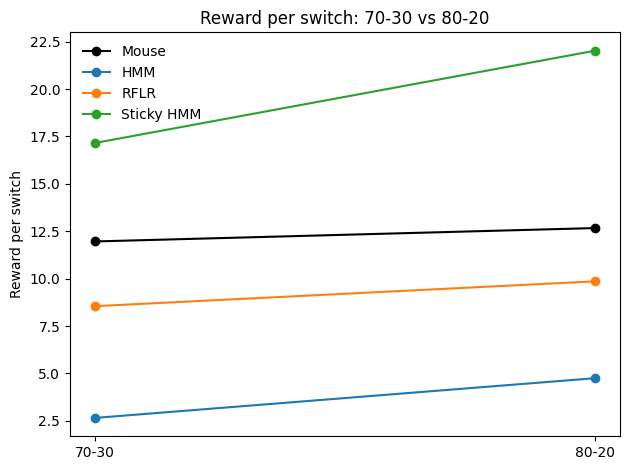

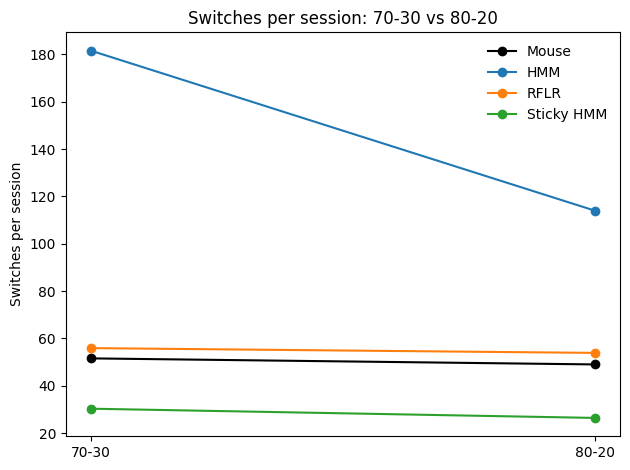

In [212]:
cond_order = ["70-30", "80-20"]
model_order = ["Mouse", "HMM", "RFLR", "Sticky HMM"]
model_colors = {
    "Mouse": "black",
    "HMM": "#1f77b4",  # blue
    "RFLR": "#ff7f0e",  # orange
    "Sticky HMM": "#2ca02c",  # green
}

for metric, ylabel, fname in [
    ("reward_per_switch", "Reward per switch", "cmp_reward_per_switch.png"),
    ("switches", "Switches per session", "cmp_switches.png"),
]:
    plt.figure()
    for m in model_order:
        s = compare[compare["model"] == m].copy()
        s["cond"] = pd.Categorical(s["cond"], categories=cond_order, ordered=True)
        s = s.sort_values("cond")
        plt.plot(s["cond"], s[metric], "o-", label=m, color=model_colors[m])
    plt.ylabel(ylabel)
    plt.title(f"{ylabel}: 70-30 vs 80-20")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=300, bbox_inches="tight")
    plt.show()

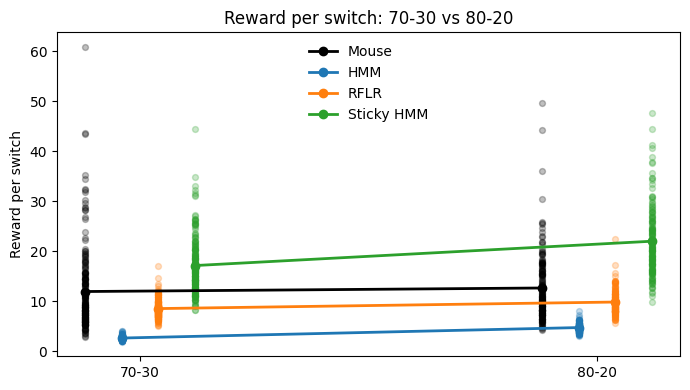

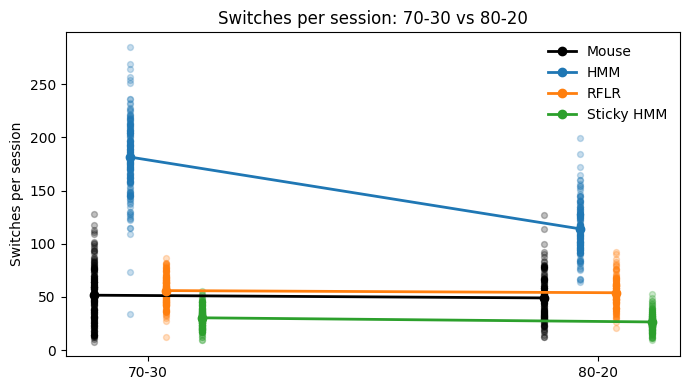

In [213]:
for metric, ylabel, fname in [
    ("reward_per_switch", "Reward per switch", "cmp_reward_per_switch_points.png"),
    ("switches", "Switches per session", "cmp_switches_points.png"),
]:
    plt.figure(figsize=(7, 4))

    for i, m in enumerate(model_order):
        s_raw = summary[summary["model"] == m].copy()
        s_raw["cond"] = pd.Categorical(
            s_raw["cond"], categories=cond_order, ordered=True
        )
        s_raw = s_raw.sort_values("cond")

        # optional dodge
        offset = (i - (len(model_order) - 1) / 2) * 0.08
        x_map = {c: j for j, c in enumerate(cond_order)}

        x = s_raw["cond"].map(x_map).astype(float).to_numpy() + offset
        y = s_raw[metric].to_numpy()
        plt.scatter(x, y, s=18, alpha=0.25, color=model_colors[m])

        # mean line from compare table
        s_mean = compare[compare["model"] == m].copy()
        s_mean["cond"] = pd.Categorical(
            s_mean["cond"], categories=cond_order, ordered=True
        )
        s_mean = s_mean.sort_values("cond")
        xm = s_mean["cond"].map(x_map).astype(float).to_numpy() + offset
        ym = s_mean[metric].to_numpy()
        plt.plot(xm, ym, "o-", label=m, color=model_colors[m], linewidth=2)

    plt.xticks([0, 1], cond_order)
    plt.ylabel(ylabel)
    plt.title(f"{ylabel}: 70-30 vs 80-20")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=300, bbox_inches="tight")
    plt.show()